# 🔧 ToyTire - Démo Déformation Mécanique

**Modèle : Anneau Rigide (Rigid Ring)**

Ce notebook montre :
1. Génération d'une épure de pneu
2. Calcul des propriétés mécaniques (K_vert, masse, performance)
3. Simulation de l'écrasement sous charge verticale

**Juste exécuter toutes les cellules !**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.ndimage import map_coordinates
from dataclasses import dataclass, field
from typing import Dict

print("✓ Imports OK")

✓ Imports OK


## 1. Générateur de pneu

In [ ]:
def generate_components(resolution=64, y_top=8, y_bottom=56, w_belly=24, w_bottom=14,
                        belly_position=0.40, thickness_carcass=4, thickness_crown=5,
                        thickness_flanks_bottom=2, lip_rounding=3):
    """Génère les 3 composants du pneu."""
    cx = resolution // 2
    thickness_carcass = min(thickness_carcass, thickness_crown)
    y_belly = int(y_top + belly_position * (y_bottom - y_top))
    arc_height = y_belly - y_top
    flank_height = y_bottom - y_belly
    
    carcass = np.zeros((resolution, resolution), dtype=np.float32)
    crown = np.zeros((resolution, resolution), dtype=np.float32)
    flanks = np.zeros((resolution, resolution), dtype=np.float32)
    
    ellipse_rx_outer, ellipse_ry_outer = w_belly, arc_height
    ellipse_rx_inner = max(0, w_belly - thickness_carcass)
    ellipse_ry_inner = max(0, arc_height - thickness_carcass)
    y_lip_start = y_bottom - lip_rounding
    thickness_flanks_top = thickness_crown
    
    for y in range(resolution):
        if y < y_top or y > y_bottom: continue
        if y <= y_belly:
            dy = y - y_belly
            ro = (dy / ellipse_ry_outer) ** 2 if ellipse_ry_outer > 0 else 0
            w_outer = ellipse_rx_outer * np.sqrt(max(0, 1 - ro)) if ro <= 1 else 0
            ri = (dy / ellipse_ry_inner) ** 2 if ellipse_ry_inner > 0 else 0
            w_inner = ellipse_rx_inner * np.sqrt(max(0, 1 - ri)) if ri <= 1 and ellipse_rx_inner > 0 else 0
        else:
            t = (y - y_belly) / flank_height if flank_height > 0 else 0
            ts = 0.5 * (1 - np.cos(np.pi * t))
            w_outer = w_belly + ts * (w_bottom - w_belly)
            w_inner = max(0, w_outer - thickness_carcass)
            if y >= y_lip_start and lip_rounding > 0:
                dl = y - y_lip_start
                if dl <= lip_rounding:
                    lc = lip_rounding * (1 - np.sqrt(max(0, 1 - (dl/lip_rounding)**2)))
                    w_outer -= lc * 0.5; w_inner += lc * 0.5
        for x in range(resolution):
            if w_inner <= abs(x - cx) <= w_outer: carcass[y, x] = 1
    
    crown_rx, crown_ry = ellipse_rx_outer + thickness_crown, ellipse_ry_outer + thickness_crown
    for y in range(resolution):
        if y > y_belly: continue
        dy = y - y_belly
        rcr = (dy / crown_ry) ** 2 if crown_ry > 0 else 0
        if rcr > 1: continue
        w_cr = crown_rx * np.sqrt(1 - rcr)
        ro = (dy / ellipse_ry_outer) ** 2 if ellipse_ry_outer > 0 else 0
        w_carc = ellipse_rx_outer * np.sqrt(max(0, 1 - ro)) if ro <= 1 else 0
        for x in range(resolution):
            d = abs(x - cx)
            if w_carc < d <= w_cr: crown[y, x] = 1
            elif d <= w_cr and carcass[y, x] == 0 and y < y_top + thickness_crown: crown[y, x] = 1
    crown = crown * (1 - carcass)
    
    for y in range(resolution):
        if y <= y_belly or y > y_bottom: continue
        t = (y - y_belly) / flank_height if flank_height > 0 else 0
        ts = 0.5 * (1 - np.cos(np.pi * t))
        w_carc = w_belly + ts * (w_bottom - w_belly)
        if y >= y_lip_start and lip_rounding > 0:
            dl = y - y_lip_start
            if dl <= lip_rounding:
                w_carc -= lip_rounding * (1 - np.sqrt(max(0, 1 - (dl/lip_rounding)**2))) * 0.5
        w_fl = w_carc + thickness_flanks_top + t * (thickness_flanks_bottom - thickness_flanks_top)
        for x in range(resolution):
            if w_carc < abs(x - cx) <= w_fl: flanks[y, x] = 1
    flanks = flanks * (1 - carcass) * (1 - crown)
    
    return {'carcass': carcass, 'crown': crown, 'flanks': flanks,
            'full': ((carcass + crown + flanks) > 0).astype(np.float32)}

print("✓ Générateur OK")

✓ Générateur OK


## 2. Module de mécanique - Modèle Anneau Rigide

```
        Force F (poids véhicule)
              ↓
        ┌─────────────┐  ← Couronne descend UNIFORMÉMENT
        │             │     de δ = F / K_vert
        │   PNEU      │  
        │             │
        └─────────────┘  ← Base FIXÉE sur jante
        ═══════════════
             JANTE
```

**Avantages :** Pas de déconnexion, physiquement défendable !

In [3]:
@dataclass
class TireMechanics:
    """Mécanique du pneu - Modèle Anneau Rigide."""
    E_carcass: float = 1.0
    E_crown: float = 0.8
    E_flanks: float = 0.5
    rho_carcass: float = 1.0
    rho_crown: float = 1.2
    rho_flanks: float = 0.8
    max_strain: float = 0.3
    
    def compute_properties(self, carcass, crown, flanks) -> Dict:
        """Calcule K_vert (ressorts/colonne), masse, performance."""
        c = (carcass > 0.5).astype(np.float32)
        cr = (crown > 0.5).astype(np.float32)
        f = (flanks > 0.5).astype(np.float32)
        full = (c + cr + f) > 0
        
        if full.sum() == 0:
            return {'K_vert': 0, 'mass_index': 0, 'performance_index': 0}
        
        rows = np.where(full.any(axis=1))[0]
        cols = np.where(full.any(axis=0))[0]
        height_px = rows.max() - rows.min() + 1
        
        K_vert = 0.0
        for x in range(cols.min(), cols.max() + 1):
            col = full[:, x]
            if col.sum() == 0: continue
            A_x = col.sum()
            act = np.where(col)[0]
            L_x = act.max() - act.min() + 1
            E_eff = (c[:, x].sum() * self.E_carcass + cr[:, x].sum() * self.E_crown + 
                     f[:, x].sum() * self.E_flanks) / max(A_x, 1)
            K_vert += E_eff * A_x / L_x
        
        mass = c.sum() * self.rho_carcass + cr.sum() * self.rho_crown + f.sum() * self.rho_flanks
        perf = K_vert / mass if mass > 0 else 0
        
        return {'K_vert': K_vert, 'mass_index': mass, 'performance_index': perf, 'height_px': height_px}
    
    def apply_load(self, carcass, crown, flanks, force=100.0):
        """Applique force verticale (modèle anneau rigide)."""
        c = (carcass > 0.5).astype(np.float32)
        cr = (crown > 0.5).astype(np.float32)
        f = (flanks > 0.5).astype(np.float32)
        res = c.shape[0]
        full = (c + cr + f) > 0
        
        if full.sum() == 0:
            return {'carcass': c, 'crown': cr, 'flanks': f, 'full': full, 
                    'displacement': np.zeros_like(c), 'delta': 0}
        
        props = self.compute_properties(c, cr, f)
        K = props['K_vert']
        if K == 0: return {'carcass': c, 'crown': cr, 'flanks': f, 'full': full,
                          'displacement': np.zeros_like(c), 'delta': 0}
        
        rows = np.where(full.any(axis=1))[0]
        y_top, y_bottom = rows.min(), rows.max()
        h = y_bottom - y_top + 1
        
        delta = min(force / K, h * self.max_strain)
        
        # Champ de déplacement cinématique (compression verticale + bulge latéral).
# Justification: quasi-statique Fz ≈ K_vert * δ (linéarisation), et couplage transverse
# via effet de Poisson (élastomère quasi-incompressible) : ε_x ≈ -ν ε_y.
nu = 0.49  # Poisson (valeur typique pour caoutchouc quasi-incompressible)

disp_y = np.zeros((res, res), dtype=np.float32)
bulge_w = np.zeros((res, res), dtype=np.float32)
for y in range(y_top, y_bottom + 1):
    t = (y_bottom - y) / h  # t=0 en bas (rim/sol), t=1 en haut (couronne)
    # Déplacement vertical affine (anneau "rigide" au 1er ordre)
    disp_y[y, :] = delta * t

    # Bulge latéral: maximal sur les flancs (milieu de la hauteur), nul au contact et au sommet.
    # w(t)=4 t (1-t) ∈ [0,1]
    bulge_w[y, :] = 4.0 * t * (1.0 - t)

yc, xc = np.meshgrid(np.arange(res), np.arange(res), indexing='ij')
x0 = (res - 1) / 2.0

# Strain vertical moyen ≈ -delta/h  →  εx ≈ nu * delta/h
eps_x = nu * (delta / max(h, 1))
disp_x = eps_x * bulge_w * (xc - x0)

new_y = yc - disp_y
new_x = xc - disp_x

def warp(img):
    return (map_coordinates(img, [new_y, new_x], order=1, mode='constant', cval=0) > 0.5).astype(np.float32)

# Ré-impose la partition (pas d'intersection) après interpolation/seuillage.
c_w  = warp(c)
cr_w = warp(cr) * (1.0 - c_w)
f_w  = warp(f)  * (1.0 - c_w) * (1.0 - cr_w)
full_w = ((c_w + cr_w + f_w) > 0).astype(np.float32)

return {'carcass': c_w, 'crown': cr_w, 'flanks': f_w,
        'full': full_w, 'displacement': disp_y, 'displacement_x': disp_x, 'delta': delta}

print("✓ TireMechanics OK (modèle anneau rigide)")

NameError: name 'res' is not defined

In [ ]:
# @dataclass
# class TireMechanics:
#     """Mécanique du pneu - Modèle Anneau Rigide."""
#     E_carcass: float = 1.0
#     E_crown: float = 0.8
#     E_flanks: float = 0.5
#     rho_carcass: float = 1.0
#     rho_crown: float = 1.2
#     rho_flanks: float = 0.8
#     max_strain: float = 0.3  # déformation max relative (en % de la hauteur)

#     def compute_properties(self, carcass, crown, flanks) -> Dict:
#         """Calcule K_vert (ressorts/colonne), masse, performance."""
#         c  = (carcass > 0.5).astype(np.float32)
#         cr = (crown   > 0.5).astype(np.float32)
#         f  = (flanks  > 0.5).astype(np.float32)
#         full = ((c + cr + f) > 0).astype(np.float32)

#         res = full.shape[0]

#         # Si rien n'est dessiné, on renvoie des zéros
#         if full.sum() == 0:
#             return {
#                 "K_vert": 0.0,
#                 "mass": 0.0,
#                 "delta_rel": 0.0,
#                 "performance": 0.0,
#                 "R_out": 0.0,
#                 "k_per_column": np.zeros(res, dtype=np.float32),
#                 "full": full,
#             }

#         # Hauteur occupée et rayon extérieur équivalent
#         rows = np.where(full.any(axis=1))[0]
#         cols = np.where(full.any(axis=0))[0]
#         y_top, y_bottom = rows.min(), rows.max()
#         height = y_bottom - y_top + 1
#         R_out = height / 2.0

#         K_vert = 0.0
#         k_per_column = np.zeros(res, dtype=np.float32)

#         for x in range(res):
#             col_full = full[:, x]
#             if not col_full.any():
#                 k_per_column[x] = 0.0
#                 continue

#             A_x = col_full.sum()
#             active_rows = np.where(col_full)[0]
#             L_x = active_rows.max() - active_rows.min() + 1

#             A_c  = c[:, x].sum()
#             A_cr = cr[:, x].sum()
#             A_f  = f[:, x].sum()

#             E_num = (
#                 self.E_carcass * A_c +
#                 self.E_crown   * A_cr +
#                 self.E_flanks  * A_f
#             )
#             E_eff = E_num / max(A_x, 1.0)

#             k_x = E_eff * A_x / max(L_x, 1.0)
#             k_per_column[x] = k_x
#             K_vert += k_x

#         mass = (
#             c.sum()  * self.rho_carcass +
#             cr.sum() * self.rho_crown +
#             f.sum()  * self.rho_flanks
#         )

#         if K_vert > 0 and R_out > 0:
#             delta_rel = 1.0 / (K_vert * R_out)
#         else:
#             delta_rel = 0.0

#         performance = (K_vert / mass) if mass > 0 else 0.0

#         return {
#             "K_vert": float(K_vert),
#             "mass": float(mass),
#             "mass_index": float(mass),              # alias pour compatibilité
#             "delta_rel": float(delta_rel),
#             "performance": float(performance),
#             "performance_index": float(performance),# alias pour compatibilité
#             "R_out": float(R_out),
#             "k_per_column": k_per_column,
#             "full": full,
#         }


#     def apply_load(self, carcass, crown, flanks, force: float) -> Dict:
#         """
#         Applique une charge verticale 'force' en modèle ANNEAU RIGIDE :
#         - la jante (base) est fixée,
#         - toute la section au-dessus se rapproche de la jante
#           avec un champ de déplacement vertical uniforme (affine en y).
#         """
#         props = self.compute_properties(carcass, crown, flanks)
#         full = props["full"]
#         K_vert = props["K_vert"]

#         res = full.shape[0]

#         if K_vert <= 0 or full.sum() == 0:
#             disp = np.zeros((res, res), dtype=np.float32)

#             def warp(img):
#                 return (img > 0.5).astype(np.float32)

#             return {
#                 "carcass": warp(carcass),
#                 "crown": warp(crown),
#                 "flanks": warp(flanks),
#                 "full": warp(full),
#                 "displacement": disp,
#                 "delta": 0.0,
#                 "K_vert": float(K_vert),
#                 "mass": float(props["mass"]),
#                 "performance": float(props["performance"]),
#             }

#         # Déflexion globale équivalente (en pixels)
#         rows = np.where(full.any(axis=1))[0]
#         y_top, y_bottom = rows.min(), rows.max()
#         height = y_bottom - y_top + 1

#         delta = force / K_vert  # F/K
#         max_delta = self.max_strain * height
#         if delta > max_delta:
#             delta = max_delta

#         # Modèle anneau rigide :
#         # base (jante) fixée en y_bottom, sommet (y_top) descend de delta.
#         disp = np.zeros((res, res), dtype=np.float32)
#         H_eff = float(height)

#         for y in range(y_top, y_bottom + 1):
#             # t = 0 à la jante (bas), t = 1 au sommet
#             t = (y_bottom - y) / H_eff
#             t = max(0.0, min(1.0, t))
#             disp[y, :] = t * delta   # déplacement VERS LE BAS (y augmente)

#         yc, xc = np.meshgrid(
#             np.arange(res), np.arange(res), indexing="ij"
#         )
#         new_y = yc + disp  # + => rapprochement de la jante (en bas)

#         def warp(img):
#             return (
#                 map_coordinates(
#                     img, [new_y, xc],
#                     order=1, mode="constant", cval=0.0
#                 ) > 0.5
#             ).astype(np.float32)

#         return {
#             "carcass": warp(carcass),
#             "crown": warp(crown),
#             "flanks": warp(flanks),
#             "full": warp(full),
#             "displacement": disp,
#             "delta": float(delta),
#             "K_vert": float(K_vert),
#             "mass": float(props["mass"]),
#             "mass_index": float(props["mass"]),              # alias
#             "performance": float(props["performance"]),
#             "performance_index": float(props["performance"]),# alias
#         }

    

# print("✓ TireMechanics OK (modèle anneau rigide corrigé)")


✓ TireMechanics OK (modèle anneau rigide corrigé)


## 3. Générer et analyser un pneu

In [ ]:
tire = generate_components()
mechanics = TireMechanics()
props = mechanics.compute_properties(tire['carcass'], tire['crown'], tire['flanks'])

print("=" * 50)
print("PROPRIÉTÉS MÉCANIQUES")
print("=" * 50)
print(f"  K_vert (raideur)      : {props['K_vert']:.2f}")
print(f"  Masse                 : {props['mass_index']:.0f}")
print(f"  Performance (K/masse) : {props['performance_index']:.4f}")
print(f"\n  → Pour δ=10px, il faut F ≈ {props['K_vert'] * 10:.0f}")
print("=" * 50)

PROPRIÉTÉS MÉCANIQUES
  K_vert (raideur)      : 41.77
  Masse                 : 1101
  Performance (K/masse) : 0.0379

  → Pour δ=10px, il faut F ≈ 418


## 4. 🎯 Visualisation AVANT / APRÈS

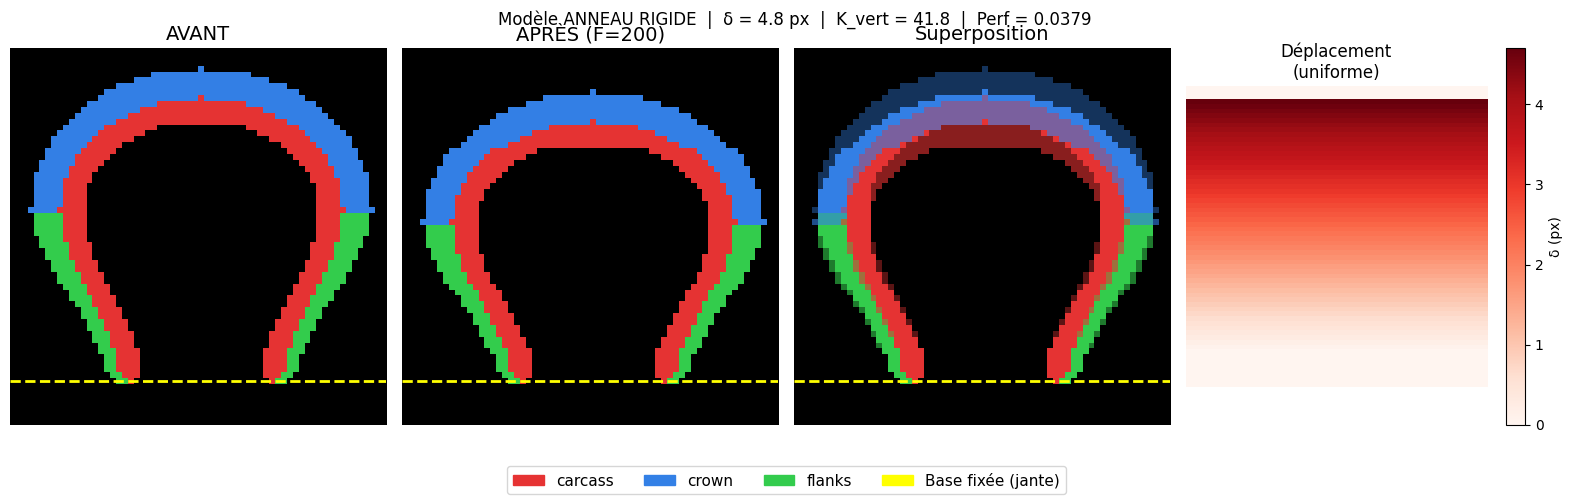


✓ Écrasement uniforme de 4.8 px (pas de déconnexion)


In [ ]:
def visualize(tire, force=200):
    mechanics = TireMechanics()
    props = mechanics.compute_properties(tire['carcass'], tire['crown'], tire['flanks'])
    deformed = mechanics.apply_load(tire['carcass'], tire['crown'], tire['flanks'], force)
    
    colors = {'carcass': [0.9, 0.2, 0.2], 'crown': [0.2, 0.5, 0.9], 'flanks': [0.2, 0.8, 0.3]}
    
    def overlay(c, cr, f):
        o = np.zeros((64, 64, 3))
        for ch in range(3):
            o[:,:,ch] += (c > 0.5) * colors['carcass'][ch]
            o[:,:,ch] += (cr > 0.5) * colors['crown'][ch]
            o[:,:,ch] += (f > 0.5) * colors['flanks'][ch]
        return np.clip(o, 0, 1)
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 5))
    
    before = overlay(tire['carcass'], tire['crown'], tire['flanks'])
    after = overlay(deformed['carcass'], deformed['crown'], deformed['flanks'])
    
    for ax in axes[:3]: ax.axhline(y=56, color='yellow', linestyle='--', linewidth=2)
    
    axes[0].imshow(before, origin='upper'); axes[0].set_title('AVANT', fontsize=14); axes[0].axis('off')
    axes[1].imshow(after, origin='upper'); axes[1].set_title(f'APRÈS (F={force})', fontsize=14); axes[1].axis('off')
    axes[2].imshow(0.4*before + 0.6*after, origin='upper'); axes[2].set_title('Superposition', fontsize=14); axes[2].axis('off')
    
    im = axes[3].imshow(deformed['displacement'], origin='upper', cmap='Reds', vmin=0)
    plt.colorbar(im, ax=axes[3], label='δ (px)')
    axes[3].set_title('Déplacement vertical\n+ bulge latéral', fontsize=12); axes[3].axis('off')
    
    patches = [mpatches.Patch(color=colors[n], label=n) for n in colors]
    patches.append(mpatches.Patch(color='yellow', label='Base fixée (jante)'))
    fig.legend(handles=patches, loc='lower center', ncol=4, fontsize=11)
    
    fig.suptitle(f"Modèle ANNEAU RIGIDE  |  δ = {deformed['delta']:.1f} px  |  "
                 f"K_vert = {props['K_vert']:.1f}  |  Perf = {props['performance_index']:.4f}", fontsize=12)
    plt.tight_layout(); plt.subplots_adjust(bottom=0.15)
    plt.show()
    
    print(f"\n✓ Écrasement: δ={deformed['delta']:.1f}px, avec bulge latéral (ν≈0.49).")

visualize(tire, force=200)

## 5. Progression avec différentes forces

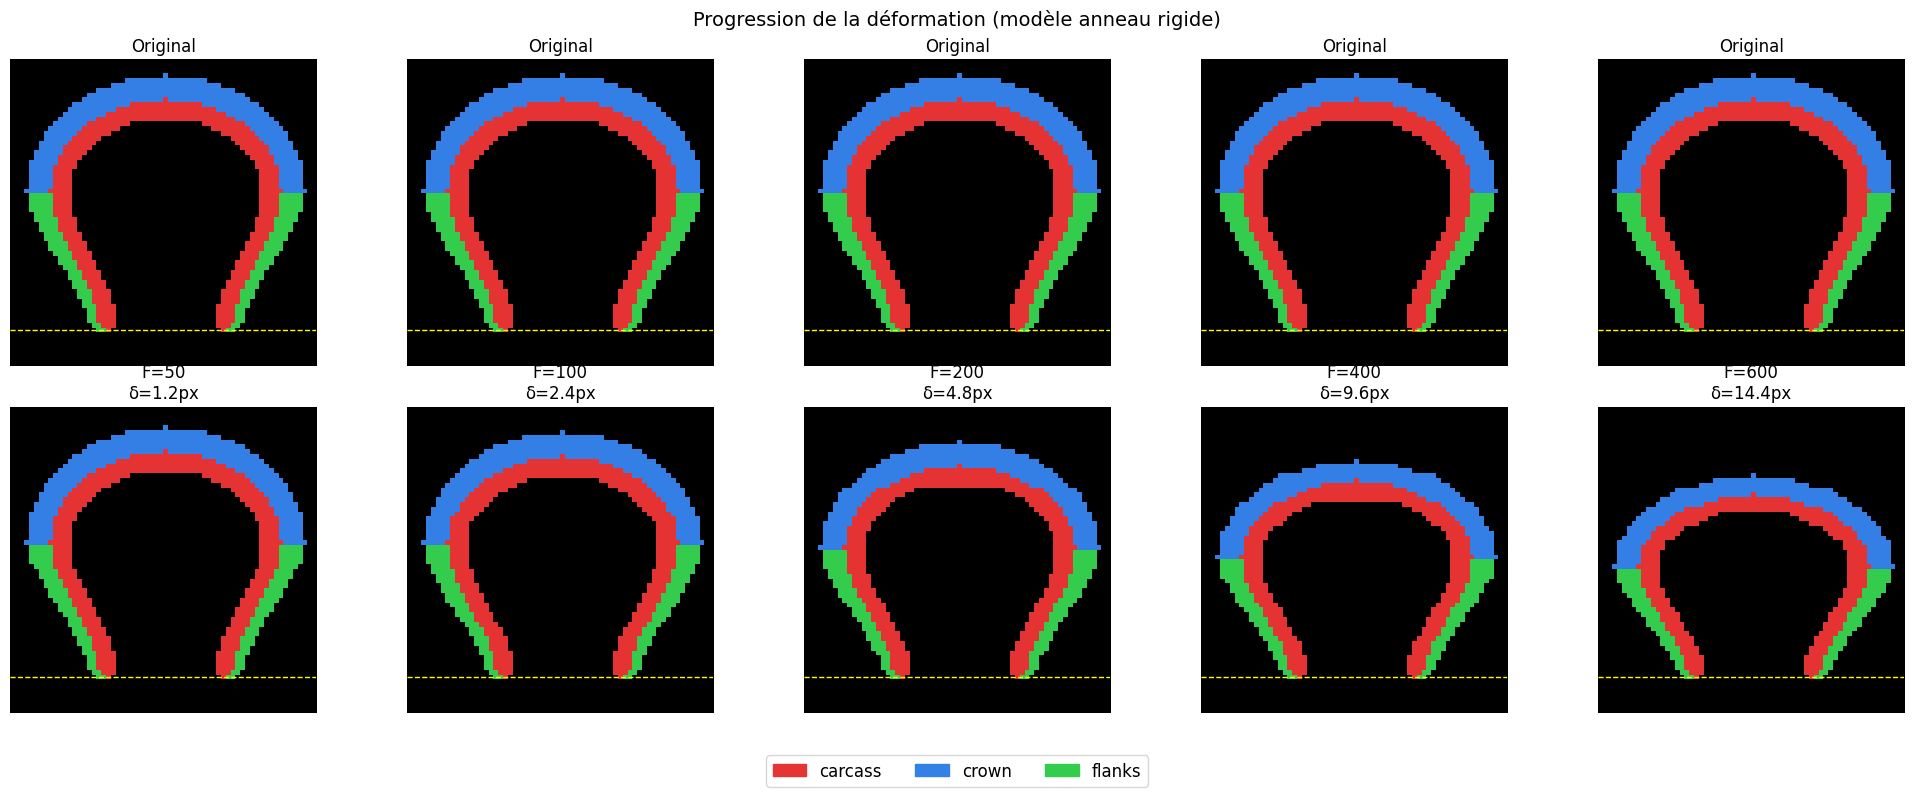

In [ ]:
def show_progression(tire, forces=[50, 100, 200, 400, 600]):
    mechanics = TireMechanics()
    colors = {'carcass': [0.9, 0.2, 0.2], 'crown': [0.2, 0.5, 0.9], 'flanks': [0.2, 0.8, 0.3]}
    
    def overlay(c, cr, f):
        o = np.zeros((64, 64, 3))
        for ch in range(3):
            o[:,:,ch] += (c > 0.5) * colors['carcass'][ch]
            o[:,:,ch] += (cr > 0.5) * colors['crown'][ch]
            o[:,:,ch] += (f > 0.5) * colors['flanks'][ch]
        return np.clip(o, 0, 1)
    
    fig, axes = plt.subplots(2, len(forces), figsize=(4*len(forces), 8))
    orig = overlay(tire['carcass'], tire['crown'], tire['flanks'])
    
    for i, F in enumerate(forces):
        def_data = mechanics.apply_load(tire['carcass'], tire['crown'], tire['flanks'], F)
        def_img = overlay(def_data['carcass'], def_data['crown'], def_data['flanks'])
        
        axes[0, i].imshow(orig, origin='upper')
        axes[0, i].axhline(y=56, color='yellow', linestyle='--', linewidth=1)
        axes[0, i].set_title('Original'); axes[0, i].axis('off')
        
        axes[1, i].imshow(def_img, origin='upper')
        axes[1, i].axhline(y=56, color='yellow', linestyle='--', linewidth=1)
        axes[1, i].set_title(f'F={F}\nδ={def_data["delta"]:.1f}px'); axes[1, i].axis('off')
    
    patches = [mpatches.Patch(color=colors[n], label=n) for n in colors]
    fig.legend(handles=patches, loc='lower center', ncol=3, fontsize=12)
    fig.suptitle('Progression de la déformation (modèle anneau rigide)', fontsize=14)
    plt.tight_layout(); plt.subplots_adjust(bottom=0.1)
    plt.show()

show_progression(tire)

## 6. Comparer différentes géométries

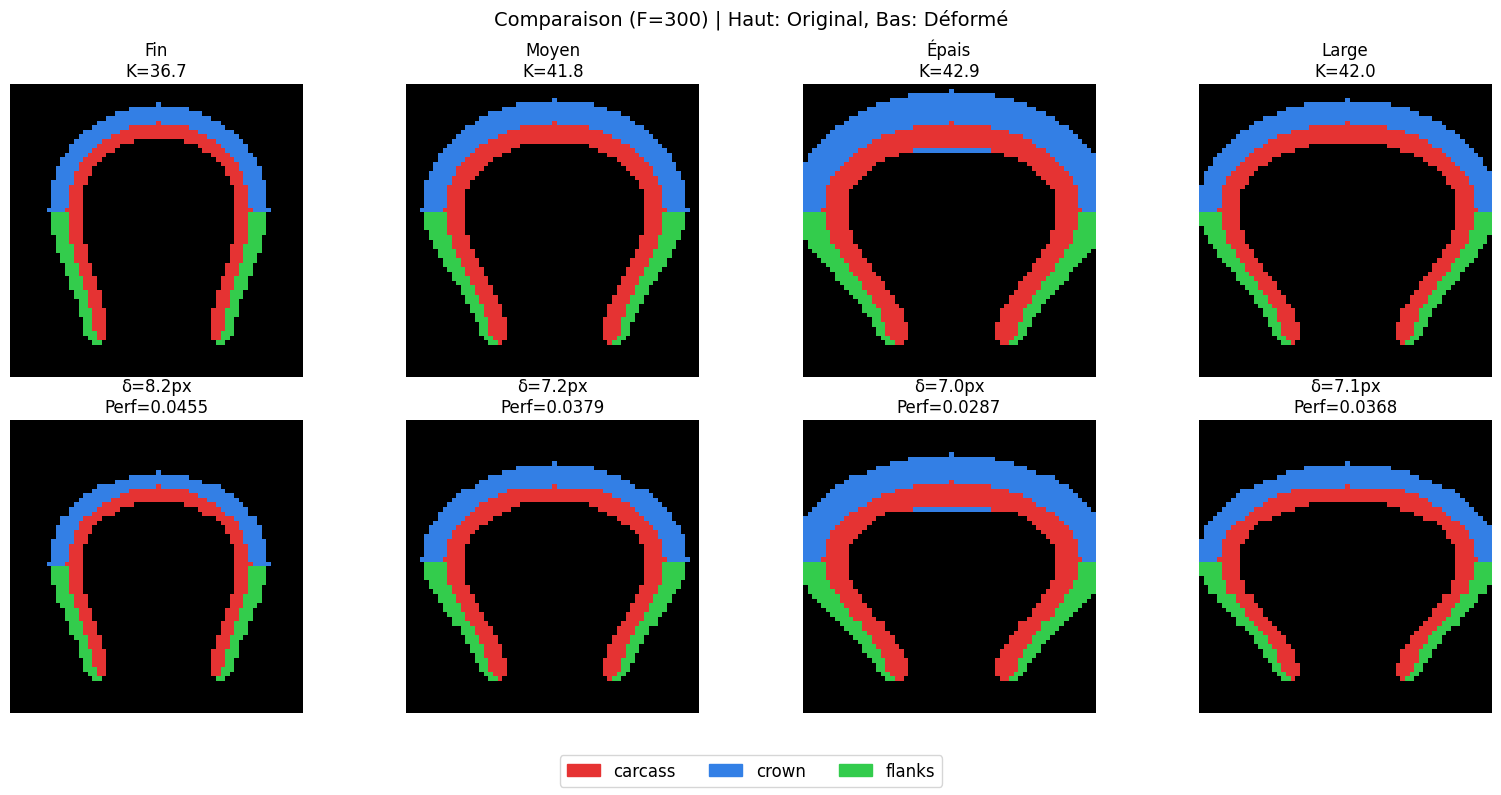


Nom          K_vert    Masse   δ (px)  Performance
-------------------------------------------------------
Fin            36.7      806      8.2      0.04550
Moyen          41.8     1101      7.2      0.03794
Épais          42.9     1495      7.0      0.02873
Large          42.0     1142      7.1      0.03681

→ Meilleure performance : Fin (meilleur ratio K/masse)


In [ ]:
def compare_geometries():
    mechanics = TireMechanics()
    configs = [
        {"name": "Fin", "thickness_carcass": 3, "thickness_crown": 4, "w_belly": 20},
        {"name": "Moyen", "thickness_carcass": 4, "thickness_crown": 5, "w_belly": 24},
        {"name": "Épais", "thickness_carcass": 5, "thickness_crown": 7, "w_belly": 28},
        {"name": "Large", "thickness_carcass": 4, "thickness_crown": 5, "w_belly": 28},
    ]
    colors = {'carcass': [0.9, 0.2, 0.2], 'crown': [0.2, 0.5, 0.9], 'flanks': [0.2, 0.8, 0.3]}
    
    def overlay(c, cr, f):
        o = np.zeros((64, 64, 3))
        for ch in range(3):
            o[:,:,ch] += (c > 0.5) * colors['carcass'][ch]
            o[:,:,ch] += (cr > 0.5) * colors['crown'][ch]
            o[:,:,ch] += (f > 0.5) * colors['flanks'][ch]
        return np.clip(o, 0, 1)
    
    fig, axes = plt.subplots(2, len(configs), figsize=(4*len(configs), 8))
    results = []
    
    for i, cfg in enumerate(configs):
        comp = generate_components(w_belly=cfg['w_belly'], thickness_carcass=cfg['thickness_carcass'],
                                   thickness_crown=cfg['thickness_crown'])
        props = mechanics.compute_properties(comp['carcass'], comp['crown'], comp['flanks'])
        deformed = mechanics.apply_load(comp['carcass'], comp['crown'], comp['flanks'], force=300)
        
        results.append({'name': cfg['name'], 'K': props['K_vert'], 'm': props['mass_index'], 
                       'perf': props['performance_index'], 'delta': deformed['delta']})
        
        axes[0, i].imshow(overlay(comp['carcass'], comp['crown'], comp['flanks']), origin='upper')
        axes[0, i].set_title(f"{cfg['name']}\nK={props['K_vert']:.1f}"); axes[0, i].axis('off')
        
        axes[1, i].imshow(overlay(deformed['carcass'], deformed['crown'], deformed['flanks']), origin='upper')
        axes[1, i].set_title(f"δ={deformed['delta']:.1f}px\nPerf={props['performance_index']:.4f}")
        axes[1, i].axis('off')
    
    patches = [mpatches.Patch(color=colors[n], label=n) for n in colors]
    fig.legend(handles=patches, loc='lower center', ncol=3, fontsize=12)
    fig.suptitle('Comparaison (F=300) | Haut: Original, Bas: Déformé', fontsize=14)
    plt.tight_layout(); plt.subplots_adjust(bottom=0.1)
    plt.show()
    
    print("\n" + "=" * 55)
    print(f"{'Nom':<10} {'K_vert':>8} {'Masse':>8} {'δ (px)':>8} {'Performance':>12}")
    print("-" * 55)
    for r in results:
        print(f"{r['name']:<10} {r['K']:>8.1f} {r['m']:>8.0f} {r['delta']:>8.1f} {r['perf']:>12.5f}")
    best = max(results, key=lambda x: x['perf'])
    print(f"\n→ Meilleure performance : {best['name']} (meilleur ratio K/masse)")

compare_geometries()

---

## 📋 Résumé

### Modèle : **Anneau Rigide** (Rigid Ring)

- **Métriques** : K_vert calculé par ressorts/colonne (physique)
- **Visualisation** : Déplacement uniforme horizontalement (propre)
- **Avantage** : Pas de déconnexion entre composants

### Pour les modèles génératifs :
- **CSV** : K_vert, mass_index, performance_index
- **Dataset augmenté** : paires (original, déformé) comme targets